In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import os
import datetime
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

import pickle
import sys
import matplotlib.pyplot as plt
# just set the seed for the random number generator
np.random.seed(107)

import numpy as np
np.random.seed(1) # NumPy
import random
random.seed(3) # Python
import tensorflow as tf

from keras import backend as K

import matplotlib.cm as cm

from sklearn.manifold import TSNE

from keras.layers import Dense, Flatten, LSTM, Dropout

In [2]:
# Usando Google Colab:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/Python/MEU_TCC/Classes')
pasta = str("/content/drive/MyDrive/Python/MEU_TCC/Data/")
print(pasta)

preços = pd.read_csv(pasta + "Preços.csv",index_col='Data',parse_dates=True)
semestres = pd.read_csv(pasta + "Semestres.csv",parse_dates=True)

Datas = pd.DataFrame(preços.index)
Datas['indice'] = Datas.index
log_data = np.log(preços)


Mounted at /content/drive
/content/drive/MyDrive/Python/MEU_TCC/Data/


In [3]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

In [4]:
top_n = 20
subsample = 2500
min_half_life = 0 # number of points in a day
max_half_life = 200000 #~number of points in a year: 78*252
file_extension = 'intraday'

# Calculando Renda fixa anualizada:

In [5]:
pastaC = str("/content/drive/MyDrive/Python/MEU_TCC/Data/")
CDI_ret = pd.read_csv(pastaC + "CDI_ret.csv", )
# Convert the 'data' column to datetime format
CDI_ret.index = pd.to_datetime(CDI_ret['Data'])
CDI_ret.drop(['Data'],inplace=True,axis=1)

CDI_ret = CDI_ret[1:]

In [6]:
anoi = 1996
rfannualized = pd.DataFrame(columns=['retorno_anualizado'])
inicio = 0

for nsem in range(0, len(semestres) - 2,2):
    print(f"Starting period {nsem} | Past days: {inicio}")
    ano = math.floor(anoi + nsem/2)
    print(ano)

    # Listando os dias dos intervalos
    inicio = (Datas == semestres['Data'][nsem]).query("Data == True").index[0]
    inicio = Datas.iloc[inicio][0]

    twelve_months = (Datas == semestres['Data'][nsem + 2]).query("Data == True").index[0]
    twelve_months = Datas.iloc[twelve_months][0]
    print('inicio: ',inicio,' twelve_months: ',twelve_months)


    annualized_ret = (np.cumprod(1 + CDI_ret['CDI Acumulado'][inicio:twelve_months]) - 1)[-1]
    rfannualized.loc[ano] = annualized_ret

rf_mean_ano = rfannualized.mean()[0]

Starting period 0 | Past days: 0
1996
inicio:  1996-01-02 00:00:00  twelve_months:  1996-12-31 00:00:00
Starting period 2 | Past days: 1996-01-02 00:00:00
1997
inicio:  1996-12-31 00:00:00  twelve_months:  1997-12-31 00:00:00
Starting period 4 | Past days: 1996-12-31 00:00:00
1998
inicio:  1997-12-31 00:00:00  twelve_months:  1998-12-31 00:00:00
Starting period 6 | Past days: 1997-12-31 00:00:00
1999
inicio:  1998-12-31 00:00:00  twelve_months:  1999-12-31 00:00:00
Starting period 8 | Past days: 1998-12-31 00:00:00
2000
inicio:  1999-12-31 00:00:00  twelve_months:  2000-12-29 00:00:00
Starting period 10 | Past days: 1999-12-31 00:00:00
2001
inicio:  2000-12-29 00:00:00  twelve_months:  2001-12-31 00:00:00
Starting period 12 | Past days: 2000-12-29 00:00:00
2002
inicio:  2001-12-31 00:00:00  twelve_months:  2002-12-31 00:00:00
Starting period 14 | Past days: 2001-12-31 00:00:00
2003
inicio:  2002-12-31 00:00:00  twelve_months:  2003-12-31 00:00:00
Starting period 16 | Past days: 2002-12

#Criando os Clusters

In [7]:
def cluster_size(counts):
    plt.figure()
    plt.barh(counts.index+1, counts.values)
    #plt.title('Cluster Member Counts')
    plt.yticks(np.arange(1, len(counts)+1, 1))
    plt.xlabel('ETFs within cluster', size=12)
    plt.ylabel('Cluster Id', size=12);

def plot_TSNE(X, clf, clustered_series_all):
    """
    This function makes use of t-sne to visualize clusters in 2d.
    """

    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

    # visualization
    fig = plt.figure(1, facecolor='white', figsize=(15,15), frameon=True, edgecolor='black')
    plt.clf()

    # axis in the middle
    ax = fig.add_subplot(1, 1, 1, alpha=0.9)
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_position('center')
    ax.spines['bottom'].set_alpha(0.3)
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(which='major', labelsize=18)
    #plt.axis('off')

    # etfs in cluster
    labels = clf.labels_
    x = X_tsne[(labels!=-1), 0]
    y = X_tsne[(labels!=-1), 1]
    tickers = list(clustered_series_all[clustered_series_all != -1].index)
    plt.scatter(
        x,
        y,
        s=300,
        alpha=0.75,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )
    for i, ticker in enumerate(tickers):
        plt.annotate(ticker, (x[i]-20, y[i]+12), size=15)

    # remaining etfs, not clustered
    x = X_tsne[(clustered_series_all==-1).values, 0]
    y = X_tsne[(clustered_series_all==-1).values, 1]
    tickers = list(clustered_series_all[clustered_series_all == -1].index)

    # WARNING: elimintate outliers
    #outliers = ['DTO','SCO']
    outliers = ['DZZ', 'XME']
    to_remove_x = [x[clustered_series_all[clustered_series_all==-1].index.get_loc(outliers[0])],
                   x[clustered_series_all[clustered_series_all==-1].index.get_loc(outliers[1])]]
    to_remove_y = [y[clustered_series_all[clustered_series_all==-1].index.get_loc(outliers[0])],
                   y[clustered_series_all[clustered_series_all==-1].index.get_loc(outliers[1])]]
    x = np.array([i for i in x if i not in to_remove_x])
    y= np.array([i for i in y if i not in to_remove_y])

    plt.scatter(
        x,
        y,
        s=150,
        alpha=0.20,
        c='black'
    )
    #for i, ticker in enumerate(tickers):
    #    plt.annotate(ticker, (x[i]+20, y[i]+20))#, arrowprops={'arrowstyle':'simple'})

    #plt.title('OPTICS clusters visualized with t-SNE', size=16);
    plt.xlabel('t-SNE Dim. 1', position=(0.92,0), size=20)
    plt.ylabel('t-SNE Dim. 2', position=(0,0.92), size=20)
    ax.set_xticks(range(-300, 301, 600))
    ax.set_yticks(range(-300, 301, 600))
    #plt.savefig('DBSCAN_2014_2018_eps0_15.png', bbox_inches='tight', pad_inches=0.01)
    plt.savefig('OPTICS_2013_2017.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    # include connections - see quontopian


Starting period 0 | Past days: 0
Total of 212 tickers
Total of 54 tickers after removing tickers with Nan values
OPTICS(max_eps=5, metric='euclidean', min_samples=3)
Clusters discovered: 1
Pairs to evaluate: 1431
0    54
dtype: int64 Average cluster size:  54.0 Total stocks:  54

Cluster 0:
['VALE3', 'ITUB4', 'PETR4', 'PETR3', 'BBDC4', 'ABEV3', 'ELET3', 'BBAS3', 'ITSA4', 'GGBR4', 'BBDC3', 'CMIG4', 'VIVT3', 'ELET6', 'CSNA3', 'BRKM5', 'USIM5', 'AMBV4', 'ARCZ6', 'ARCE3', 'ARCE4', 'BESP4', 'BBAS4', 'BMTO4', 'CEVA4', 'CMET4', 'CLSC4', 'CMIG3', 'CESP5', 'CPSL3', 'DURA4', 'REPA4', 'EMBR4', 'ERIC4', 'VCPA4', 'INEP4', 'PTIP4', 'KLBN4', 'LIGT3', 'LAME4', 'OIBR4', 'PCAR4', 'PMAM4', 'PALF3', 'SDIA4', 'SHAP4', 'CSTB4', 'CRUZ3', 'SUZB5', 'VIVT4', 'UNIP6', 'VALE5', 'BRDT4-old', 'WHMT3']
Cluster 1/1

KeyboardInterrupt: 

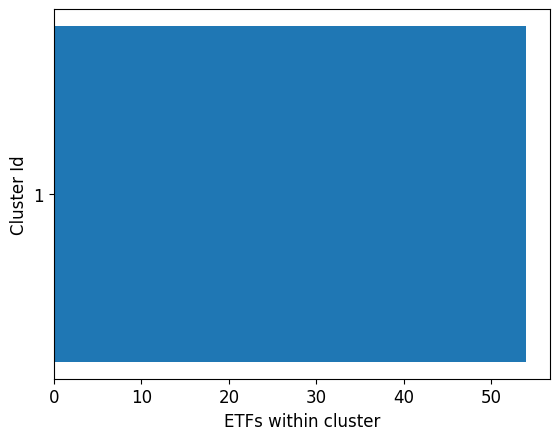

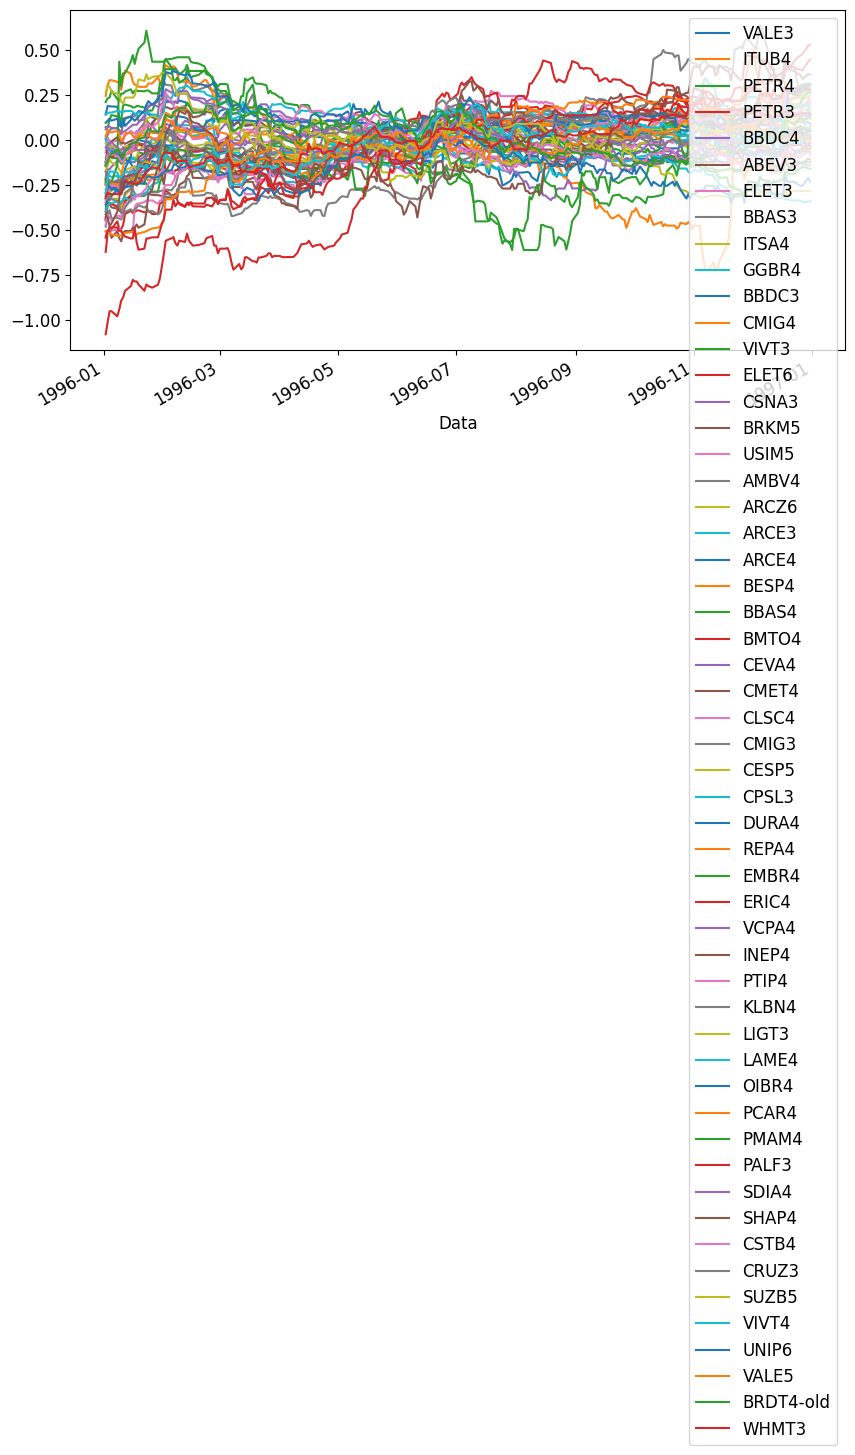

In [19]:
inicio = 0
pairs_t = []
performance_threshold_test_t = []
sharpe_results_threshold_test_nocosts_t = []
cum_returns_threshold_test_nocosts_t = []
results_t = pd.DataFrame(columns=['n_pairs','Daily_sharpe_ratio','avg_annual_roi',
                                  'Total Number of Trades','Positive Trades','Negative Trades','pct_positive_trades_per_pair',
                                  'pct_pairs_with_positive_returns','avg_half_life','avg_hurst_exponent','Maximum Drawdown'])

Pares_Total = pd.DataFrame(columns=['Ticker 1','Ticker 2','p valor'])

for big_loop in range(0,2): # len(semestres) - 3):
    print(f"\nStarting period {big_loop} | Past days: {inicio}")

    # Listando os dias dos intervalos
    inicio = (Datas == semestres['Data'][big_loop]).query("Data == True").index[0]
    inicio = Datas.iloc[inicio][0]
    twelve_month = (Datas == semestres['Data'][big_loop + 2]).query("Data == True").index[0]
    twelve_months = Datas.iloc[twelve_month][0]
    inicio_test = Datas.iloc[twelve_month+1][0]
    six_months = (Datas == semestres['Data'][big_loop + 3]).query("Data == True").index[0]
    six_months = Datas.iloc[six_months][0]

    # split data in training and test
    df_prices_train, df_prices_test = data_processor.split_data(preços,(inicio, twelve_months),(inicio_test,six_months),remove_nan=True)

    # interday
    n_years_test = round(len(df_prices_train)/(250))

    # Clusterização:
    # optics
    df_returns = data_processor.get_return_series(df_prices_train)
    X = np.transpose(df_returns)
    clustered_series_all, clustered_series, counts, clf = series_analyser.apply_OPTICS(X, df_returns, min_samples=3,
                                                                                       max_eps=5,
                                                                                       cluster_method='xi')

    cluster_size(counts)

    print(counts,'Average cluster size: ', np.mean(counts), 'Total stocks: ', np.sum(counts))

    for label_n in range(len(counts)):
      elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
      print('\nCluster {}:\n{}'.format(label_n,elements_cluster_n))

    #plot_TSNE(X,clf, clustered_series_all)

    plt.rcParams.update({'font.size': 12})
    for clust in range(len(counts)):
        symbols = list(clustered_series[clustered_series==clust].index)
        means = np.log(df_prices_train[symbols].mean())
        series = np.log(df_prices_train[symbols]).sub(means)
        series.plot(figsize=(10,5))#title='ETFs Time Series for Cluster %d' % (clust+1))
        #plt.ylabel('Normalized log prices', size=12)
        #plt.xlabel('Date', size=12)
        plt.savefig('cluster_{}.png'.format(str(clust+1)), bbox_inches='tight', pad_inches=0.1)



    pairs_all_a_all, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=clustered_series,
                                                                          pricing_df_train=df_prices_train,
                                                                          pricing_df_test=df_prices_test,
                                                                          min_half_life=min_half_life,
                                                                          max_half_life=max_half_life,
                                                                          min_zero_crosings=12,
                                                                          p_value_threshold=0.01,
                                                                          hurst_threshold=0.5,
                                                                          subsample=0,
                                                                          top_n=99999999
                                                                          )
    print('Out of {} possible combinations'.format(len(df_prices_train.columns)*(len(df_prices_train.columns)-1)/2))

    results_without_costs, results_with_costs, performance_threshold_test = \
            trader.apply_trading_strategy(pairs_all_a_all,
                                          strategy='fixed_beta',
                                          entry_multiplier=2,
                                          exit_multiplier=0,
                                          test_mode=True,
                                          train_val_split=0,
                                          rf = rfannualized
                                          )

    sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
    #sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs


    # interday
    n_years_test = round(len(df_prices_test)/(240))

    n_years_test

    results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_nocosts,
                                                      cum_returns_threshold_test_nocosts,
                                                      performance_threshold_test,
                                                      pairs_all_a_all,
                                                      n_years_test,
                                                      rf = rfannualized)

    for i in range(0, len(pairs_all_a_all)):
      Pares_Total = Pares_Total.append({'Ticker 1': pairs_all_a_all[i][0], 'Ticker 2': pairs_all_a_all[i][1], 'p valor': pairs_all_a_all[i][2]['p_value']},ignore_index=True)

    results_t = results_t.append(results,ignore_index=True)

results_t['Annualized SR'] = results_t['Daily_sharpe_ratio']*(252**0.5)

Pares_Total['Ticker Combinado'] = Pares_Total[['Ticker 1', 'Ticker 2']].apply(lambda x: '-'.join(sorted(x)), axis=1)
Pares_Total = Pares_Total.drop_duplicates(subset=['Ticker Combinado'], keep='first')

In [11]:
pd.set_option('display.float_format', '{:.10e}'.format)


In [12]:
pastaP = str("/content/drive/MyDrive/Python/MEU_TCC/Data/pickle/")

with open(pastaP + 'Clustering_Pares_Cointegrados_20.pickle', 'wb') as f:
    pickle.dump(results_t, f)

with open(pastaP + 'Clustering_Pares_Cointegrados_Lista_20.pickle', 'wb') as f:
    pickle.dump(Pares_Total, f)

In [13]:
pastaP = str("/content/drive/MyDrive/Python/MEU_TCC/Data/pickle/")

with open(pastaP + 'Clustering_Pares_Cointegrados_20.pickle', 'rb') as handle:
    results_t = pickle.load(handle)

with open(pastaP + 'Clustering_Pares_Cointegrados_Lista_20.pickle', 'rb') as handle:
    Pares_Total = pickle.load(handle)

In [14]:
# Resultados:
print('Top N Pares:',results_t['n_pairs'].min())
print('Sharpe Ratio Anualizado: {:.3f}'.format(results_t['Annualized SR'].mean()))
print('Excesso de Retornos Anualizado: {:.3f} %'.format(results_t['avg_annual_roi'].mean()))
print('MDD: {:.3f} %'.format(results_t['Maximum Drawdown'].min()))
print('Total de Pares:', Pares_Total['Ticker Combinado'].count()) # Não está contando a repetição dos pares
print('Pares rentáveis: {:.3f} %'.format(results_t['pct_pairs_with_positive_returns'].mean()))
print('Total de Transações:', results_t['Total Number of Trades'].sum())
print('Operações rentáveis:', results_t['Positive Trades'].sum())
print('Operações deficitárias :', results_t['Negative Trades'].sum())

Top N Pares: 3
Sharpe Ratio Anualizado: -0.788
Excesso de Retornos Anualizado: 13.142 %
MDD: -5.242 %
Total de Pares: 51
Pares rentáveis: 69.343 %
Total de Transações: 54
Operações rentáveis: 43
Operações deficitárias : 11
